In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle

from keras.layers import Conv2D,Conv2DTranspose,Dense,MaxPool2D,Concatenate,Activation,BatchNormalization,GlobalAveragePooling2D
from keras.models import Model,Input,load_model,save_model

#Downloading Data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manavgarg663","key":"31283f5fd4f31c90e3d276b73f1d839d"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 80.9MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.7MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip -d train

removing unnecessary file

In [ ]:
%rm -rf '/content/chest-xray-pneumonia.zip'

In [ ]:
%rm -rf '/content/train/chest_xray/__MACOSX'

In [ ]:
%rm -rf '/content/train/chest_xray/chest_xray'

#Visualisation of data

In [ ]:
dir = '/content/train/chest_xray/train'

In [ ]:
list_dir = os.listdir(dir)

In [ ]:
class_names = ["NORMAL","PNUEMONIA"]

Visulaizing Shape and image 

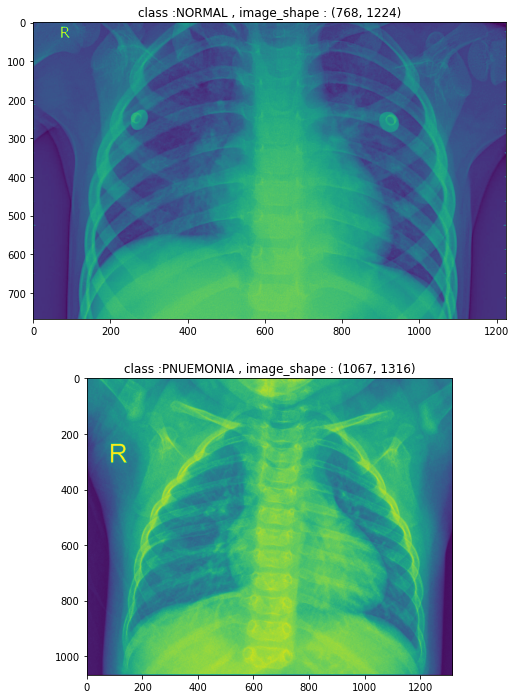

In [ ]:
fig = plt.figure(figsize=(10,12))
for count,class_name in enumerate(list_dir):

  current_class_dir = os.path.join(dir,class_name)

  sample_image = plt.imread(os.path.join(current_class_dir,os.listdir(current_class_dir)[0]))

  plt.subplot(2,1,count+1)
  plt.imshow(sample_image)
  plt.title(f"class :{class_names[count]} , image_shape : {sample_image.shape}")

#Bilateral Filtering and Histogram Equalization(need to be edited not done)

In [ ]:
sample_image = cv2.imread('/content/person1000_bacteria_2931.jpeg',0)

In [ ]:
kernel = np.ones((5,5),np.uint8)
gradient = cv2.morphologyEx(sample_image, cv2.MORPH_GRADIENT, kernel)

In [ ]:
gradient_try = (gradient > 2).astype(np.int32)

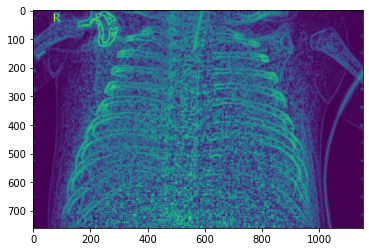

In [ ]:
gradient = gradient.astype(np.float32)
sample_image = sample_image.astype(np.float32)
sample_image = sample_image / 2
plt.imshow(sample_image)

In [ ]:
gradient = cv2.equalizeHist(gradient)

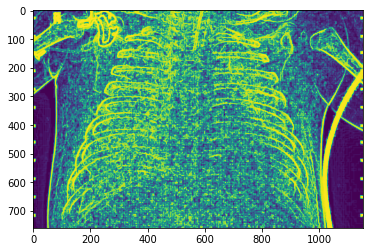

In [ ]:
plt.imshow(gradient)

In [ ]:
np.max(gradient)

255

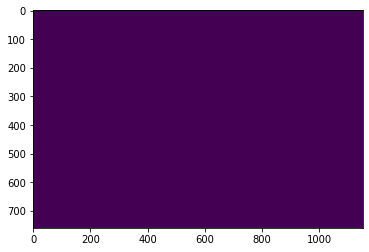

In [ ]:
# gradient = gradient.astype(np.float32)
# gradient = gradient / 255.0
sample_image = sample_image.astype(np.float32)
sample_image = sample_image * gradient_try
sample_image = sample_image / 255.0
plt.imshow(sample_image)

In [ ]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(sample_image,kernel,iterations = 1)

In [ ]:
sample_image = cv2.bilateralFilter(sample_image,15,80,80)


In [ ]:
sample_image.shape

(760, 1152)

In [ ]:
sample_image = cv2.equalizeHist(sample_image)

In [ ]:
sample_image.shape

(760, 1152)

In [ ]:
original_image = plt.imread('/content/person1000_bacteria_2931.jpeg')

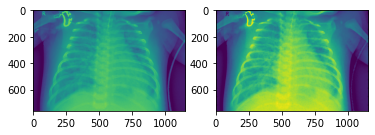

In [ ]:
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.imshow(erosion)

In [ ]:
Try = np.zeros((sample_image.shape[0],sample_image.shape[1],3),dtype=np.float32)

In [ ]:
for i in range(3):
  Try[:,:,i] = erosion

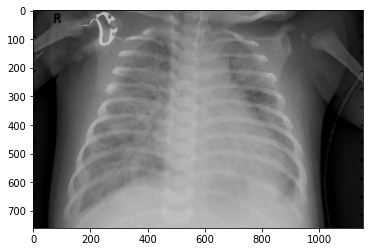

In [ ]:
Try/=255.0
plt.imshow(Try)

In [ ]:
Try.shape

(768, 1072, 3)

In [ ]:
Try = tf.image.resize(Try,size=(128,128))

In [ ]:
Try.shape

TensorShape([128, 128, 3])

In [ ]:
Try = tf.expand_dims(Try,axis=0)

In [ ]:
model  = load_model('/content/drive/MyDrive/my projects/Lung Segmentation from X-ray/saved_model/segmebation_model.h5',compile=False)

In [ ]:
sample_output = model.predict(Try)

In [ ]:
sample_output = sample_output.reshape((128,128))

In [ ]:
sample_output = (sample_output > 0.05).astype(np.int32)

In [ ]:
sample_output_1 = sample_output

In [ ]:
sample_output_2 = sample_output

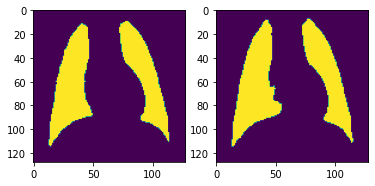

In [ ]:
plt.subplot(1,2,1)
plt.imshow(sample_output_1)
plt.subplot(1,2,2)
plt.imshow(sample_output_2)

#prepare dataset

In [ ]:
segmenation_model = load_model('/content/drive/MyDrive/my projects/Lung Segmentation from X-ray/saved_model/segmebation_model.h5',compile=False)

In [ ]:
def image_processor(image_path):
  image = cv2.imread(image_path,0)

  #bilateral filtering
  image = cv2.bilateralFilter(image,15,80,80)
   
  #histogram equalisation
  image = cv2.equalizeHist(image)

  #As our image has channel of 1 and segmentation model take input of image channel 3
  input_image = np.zeros((image.shape[0],image.shape[1],3),dtype=np.float32)

  for i in range(3):
    input_image[:,:,i] = image
  
  #normalizing input_image
  input_image = input_image/255.0

  #segmentation model take image of input (1,128,128,3) so resizing it accordingly
  input_image = tf.image.resize(input_image,(128,128))
  input_image = tf.expand_dims(input_image,axis=0)

  output_image = segmenation_model.predict(input_image)

  output_image = output_image.reshape(128,128)

  segmentation_mask = (output_image>0.05).astype(np.float32)
  
  #applying segmentation mask on input image to get our final image 
  input_image = input_image.numpy()
  input_image = input_image.reshape(128,128,3)
  processed_image = input_image.astype(np.float32)

  for i in range(3):
    processed_image[:,:,i] *= segmentation_mask
  
  return processed_image

In [ ]:
sample_image = image_processor('/content/train/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')

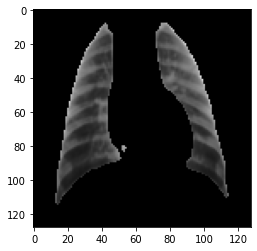

In [ ]:
plt.imshow(sample_image)

In [ ]:
def prepare_dataset(dir):

  classes_list = os.listdir(dir)
  classes_path = list(map(lambda x:os.path.join(dir,x),classes_list))

  images = []
  labels = []

  for count,current_class_path in enumerate(classes_path):

    current_images = []

    current_images_name_list = os.listdir(current_class_path)
    current_images_path = list(map(lambda x:os.path.join(current_class_path,x),current_images_name_list))

    current_images = list(map(image_processor,current_images_path))

    total_images = len(current_images)
    current_labels = [count] * total_images

    images += current_images
    labels += current_labels

  images = np.stack(images)
  labels = np.array(labels)
  m = images.shape[0]
  labels = (labels.reshape(m,1)).astype(np.int32)

  return images,labels

In [ ]:
train_images,train_labels = prepare_dataset('/content/train/chest_xray/train')

In [ ]:
train_images.shape,train_images.dtype,train_labels.shape,train_labels.dtype    

In [ ]:
train_images,train_labels = shuffle(train_images,train_labels)

temporary saving the data

In [ ]:
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/train_images.npy',train_images)
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/train_labels.npy',train_labels)

In [ ]:
val_images,val_labels = prepare_dataset('/content/train/chest_xray/val')

In [ ]:
val_images,val_labels = shuffle(val_images,val_labels)

In [ ]:
val_images.shape,val_labels.shape

temporary saving the data

In [ ]:
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/val_images.npy',val_images)
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/val_labels.npy',val_labels)

In [ ]:
test_images,test_labels = prepare_dataset('/content/train/chest_xray/test')

In [ ]:
test_images,test_labels = shuffle(test_images,test_labels)

In [ ]:
test_images.shape,test_labels.shape

temporary saving the data

In [ ]:
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_images.npy',test_images)
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_labels.npy',test_labels)

#Data Augmentation

In [ ]:
from imgaug import augmenters as iaa

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)), # rotate the image
    iaa.Fliplr(1.0)
])


In [ ]:
sample_image = train_images[23]
sample_image.shape

In [ ]:
image_aug = seq.augment_image(sample_image)

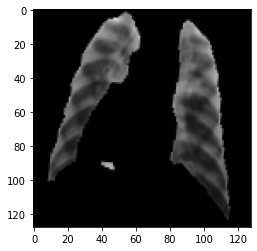

In [ ]:
plt.imshow(image_aug)

adding sequences for each type

In [ ]:
rotation_seq  = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30))])

rotation_flip_seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)), # rotate the image
    iaa.Fliplr(1.0) #do horizontal flip
])

In [ ]:
sequences = [rotation_seq,rotation_flip_seq]

In [ ]:

rotation_images = []
rotation_flip_images = []

aug_images  = [rotation_images,rotation_flip_images]

In [ ]:
for count,current_images in enumerate(aug_images):
  
  duplicate_images = train_images.copy()

  m = duplicate_images.shape[0]

  for i in range(m):

    current_seq = sequences[count]

    image_aug = current_seq.augment_image(duplicate_images[i])

    current_images.append(image_aug)

In [ ]:
train_images = np.concatenate((train_images,np.stack(aug_images[0]),np.stack(aug_images[1])))

In [ ]:
train_labels = np.concatenate((train_labels,train_labels,train_labels))

In [ ]:
train_images.shape,train_labels.shape

((15648, 128, 128, 3), (15648, 1))

In [ ]:
train_images,train_labels = shuffle(train_images,train_labels)

temporary saving the augmented data

In [ ]:
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_images.npy',test_images)
np.save('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_labels.npy',test_labels)

loading the saved augmented data

In [ ]:
test_images = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_images.npy')
test_labels = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_labels.npy')

In [ ]:
test_images.shape,test_labels.shape

((624, 128, 128, 3), (624, 1))

#Loading temporary saved data 

In [ ]:
train_images = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/train_images.npy')
train_labels = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/train_labels.npy')


In [ ]:
val_images = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/val_images.npy')
val_labels = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/val_labels.npy')


In [ ]:
test_images = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_images.npy')
test_labels = np.load('/content/drive/MyDrive/my projects/Pnuemoniua detection from Lung X-Ray/saved_numpy/test_labels.npy')


mixing train,val,test data

In [ ]:
train_images.shape,val_images.shape,test_images.shape

((5216, 128, 128, 3), (16, 128, 128, 3), (624, 128, 128, 3))

In [ ]:
images = np.concatenate((train_images,val_images,test_images))
labels = np.concatenate((train_labels,val_labels,test_labels))
images,labels = shuffle(images,labels)

In [ ]:
images.shape,labels.shape

((5856, 128, 128, 3), (5856, 1))

In [ ]:
from sklearn.model_selection import train_test_split
train_images,test_images,train_labels,test_labels = train_test_split(images,labels,test_size=0.15)

Details of train data

([<matplotlib.axis.XTick at 0x7f64b5ce32d0>,
 <a list of 2 Text major ticklabel objects>)

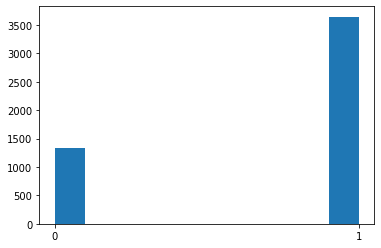

In [ ]:
plt.hist(train_labels)
plt.xticks([0,1])

In [ ]:
test_images.shape,test_labels.shape

((879, 128, 128, 3), (879, 1))

#Building and training the model

In [ ]:
base_model = tf.keras.applications.Xception(include_top=False,
    weights="imagenet",
    input_shape=(128,128,3))

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
base_model.trainable = True 

In [ ]:
def build_model(input_shape,base_model):

  inputs = Input(shape=input_shape)

  x = base_model(inputs)

  x = GlobalAveragePooling2D()(x)

  x = Dense(1024,activation='relu')(x)

  outputs = Dense(1,activation='sigmoid')(x)

  model = Model(inputs,outputs)

  return model

In [ ]:
pnuemonia_detection_model = build_model((128,128,3),base_model)

The following Variables were used a Lambda layer's call (tf.nn.convolution_12), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_80), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1_bn/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'block1_conv1_bn/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_13), but
are not present in its tracked objects:
  <tf.Vari

In [ ]:
pnuemonia_detection_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf.nn.convolution_12 (TFOpLambd (None, 63, 63, 32)   0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.nn.fused_batch_nor ((None, 63, 63, 32), 0           tf.nn.convolution_12[0][0]       
__________________________________________________________________________________________________
tf.nn.relu_70 (TFOpLambda)      (None, 63, 63, 32)   0           tf.compat.v1.nn.fused_batch_norm_
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.binary_crossentropy
pnuemonia_detection_model.compile(optimizer=optimizer,loss=loss,metrics=["accuracy"])

In [ ]:
Earlstopper = tf.keras.callbacks.EarlyStopping(patience=10,verbose=1,restore_best_weights=True)

In [ ]:
train_images.shape,train_labels.shape

((4977, 128, 128, 3), (4977, 1))

In [ ]:
train_labels  = train_labels.astype(np.float32)

In [ ]:
pnuemonia_detection_model.fit(train_images,train_labels,epochs=16,callbacks=[Earlstopper],validation_split=0.1)

Epoch 1/16
140/140 [==============================] - 14s 65ms/step - loss: 0.5441 - accuracy: 0.8209 - val_loss: 0.2565 - val_accuracy: 0.8956
Epoch 2/16
140/140 [==============================] - 6s 46ms/step - loss: 0.2317 - accuracy: 0.9028 - val_loss: 0.2566 - val_accuracy: 0.8936
Epoch 3/16
140/140 [==============================] - 7s 47ms/step - loss: 0.1940 - accuracy: 0.9275 - val_loss: 0.2517 - val_accuracy: 0.8936
Epoch 4/16
140/140 [==============================] - 7s 47ms/step - loss: 0.1770 - accuracy: 0.9320 - val_loss: 0.2514 - val_accuracy: 0.9056
Epoch 5/16
140/140 [==============================] - 7s 51ms/step - loss: 0.1543 - accuracy: 0.9430 - val_loss: 0.2573 - val_accuracy: 0.9036
Epoch 6/16
140/140 [==============================] - 7s 52ms/step - loss: 0.1695 - accuracy: 0.9331 - val_loss: 0.2239 - val_accuracy: 0.9076
Epoch 7/16
140/140 [==============================] - 7s 47ms/step - loss: 0.1345 - accuracy: 0.9513 - val_loss: 0.2396 - val_accuracy: 0.903

#Evaluating the model

In [ ]:
a = pnuemonia_detection_model.evaluate(train_images,train_labels)

156/156 [==============================] - 7s 42ms/step - loss: 0.1377 - accuracy: 0.9496


In [ ]:
a = pnuemonia_detection_model.evaluate(test_images,test_labels)

28/28 [==============================] - 3s 43ms/step - loss: 0.1936 - accuracy: 0.9204
